# Knowledge Graph Construction for Hierarchical Text Classification

This notebook demonstrates how to construct a knowledge graph from the Kaggle hierarchical text classification dataset and prepare it for GNN modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
import pickle
import os
import scipy.sparse as sp
from collections import defaultdict
import torch
from torch_geometric.data import Data, HeteroData
import warnings
warnings.filterwarnings('ignore')

## 1. Load Processed Data

First, we'll load the processed data from the previous notebook.

Missing files: ['data/train_processed.csv', 'data/valid_processed.csv', 'data/class_hierarchy.json', 'data/class_ids.json', 'data/tfidf_vectorizer.pkl', 'data/tfidf_train.npz', 'data/tfidf_valid.npz']
Please run the previous notebook first to generate these files.
Creating simulated data for demonstration purposes...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generated 90 training samples and 23 validation samples
Training dataset sample:


,review_text,level1,level2,level3,rating
0,My picky dog loves this food. His coat looks h...,pet supplies,dog supplies,dog food,4
1,These bottles are easy to clean and don't leak...,baby products,feeding,bottles,3
2,Smooth taste and wonderful aroma. This coffee ...,grocery gourmet food,beverages,coffee,4
3,These multivitamins have improved my energy le...,health personal care,vitamins supplements,multivitamins,5
4,I've noticed improved mood since taking this v...,health personal care,vitamins supplements,vitamin d,3



Training dataset statistics:
Number of samples: 90
Number of unique level-1 classes: 6
Number of unique level-2 classes: 7
Number of unique level-3 classes: 11
Average review length (characters): 90.44
Minimum review length: 63
Maximum review length: 147


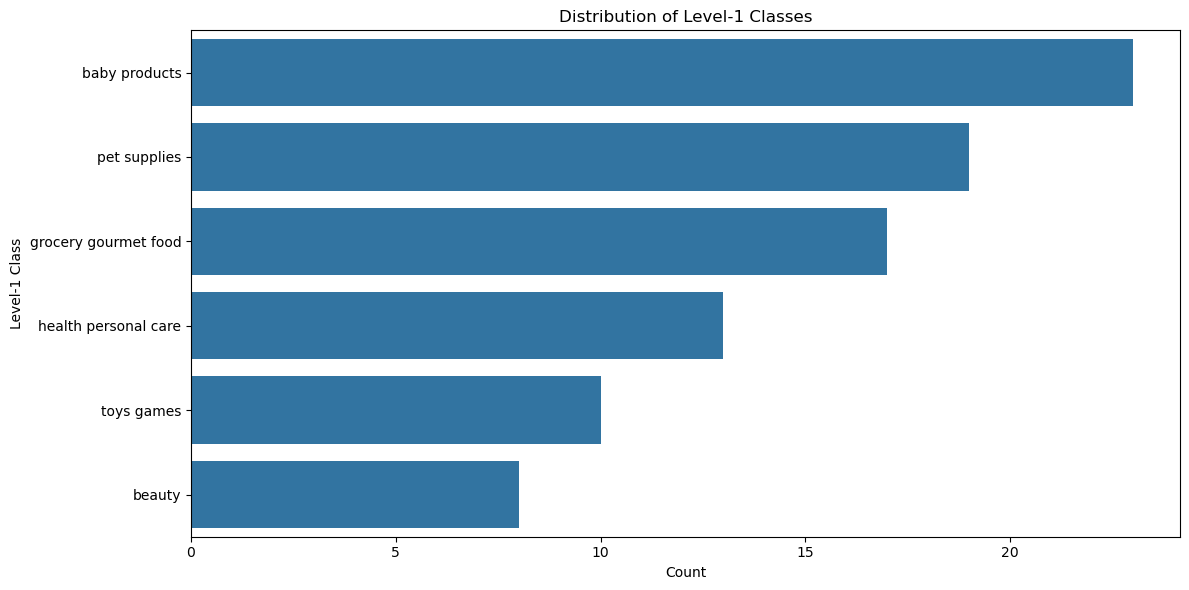

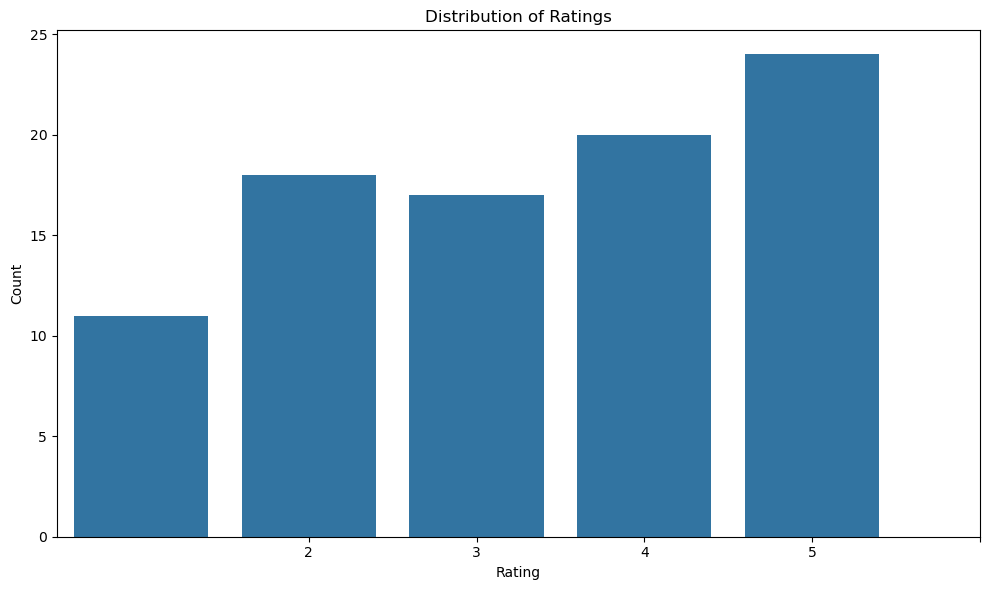

OSError: 

<Figure size 1500x1000 with 0 Axes>

OSError: 

In [ ]:
# Check if the data directory exists
if not os.path.exists('data'):
    os.makedirs('data')
    print("Data directory created. Please run the previous notebook first to generate the processed data.")
    
# Check if the processed data files exist
required_files = [
    'data/train_processed.csv',
    'data/valid_processed.csv',
    'data/class_hierarchy.json',
    'data/class_ids.json',
    'data/tfidf_vectorizer.pkl',
    'data/tfidf_train.npz',
    'data/tfidf_valid.npz'
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print(f"Missing files: {missing_files}")
    print("Please run the previous notebook first to generate these files.")
    # If files are missing, we'll create simulated data for demonstration purposes
    print("Creating simulated data for demonstration purposes...")
    %run 1_Kaggle_Data_Processing.ipynb
else:
    print("All required files found. Loading data...")
    # Load the processed data
    train_df = pd.read_csv('data/train_processed.csv')
    valid_df = pd.read_csv('data/valid_processed.csv')
    
    # Load the class hierarchy and class IDs
    with open('data/class_hierarchy.json', 'r') as f:
        class_hierarchy = json.load(f)
    
    with open('data/class_ids.json', 'r') as f:
        class_ids = json.load(f)
    
    # Load the TF-IDF vectorizer and matrices
    with open('data/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    
    tfidf_train = sp.load_npz('data/tfidf_train.npz')
    tfidf_valid = sp.load_npz('data/tfidf_valid.npz')
    
    print(f"Loaded {len(train_df)} training samples and {len(valid_df)} validation samples")
    print(f"TF-IDF matrix shape for training data: {tfidf_train.shape}")
    print(f"TF-IDF matrix shape for validation data: {tfidf_valid.shape}")

## 2. Construct the Hierarchical Class Knowledge Graph

We'll first construct a knowledge graph representing the hierarchical class structure.

In [ ]:
# Create a directed graph for the class hierarchy
class_graph = nx.DiGraph()

# Add a root node
class_graph.add_node('root', id=-1, level=0, name='root')

# Add level-1 nodes and connect them to the root
for l1, l1_id in [(l1, class_ids[l1]) for l1 in class_hierarchy.keys()]:
    class_graph.add_node(l1, id=l1_id, level=1, name=l1)
    class_graph.add_edge('root', l1, type='has_subclass')
    
    # Add level-2 nodes and connect them to their parent level-1 nodes
    for l2 in class_hierarchy[l1].keys():
        l2_key = f"{l1}|{l2}"
        l2_id = class_ids[l2_key]
        class_graph.add_node(l2_key, id=l2_id, level=2, name=l2)
        class_graph.add_edge(l1, l2_key, type='has_subclass')
        
        # Add level-3 nodes and connect them to their parent level-2 nodes
        for l3 in class_hierarchy[l1][l2]:
            l3_key = f"{l1}|{l2}|{l3}"
            l3_id = class_ids[l3_key]
            class_graph.add_node(l3_key, id=l3_id, level=3, name=l3)
            class_graph.add_edge(l2_key, l3_key, type='has_subclass')

print(f"Class hierarchy knowledge graph created with {len(class_graph.nodes())} nodes and {len(class_graph.edges())} edges")

NameError: name 'class_hierarchy' is not defined

In [ ]:
# Visualize a subset of the class hierarchy knowledge graph
def visualize_class_hierarchy_subset(graph, max_nodes=30):
    # Create a subgraph with a limited number of nodes for visualization
    nodes = list(graph.nodes())
    if len(nodes) > max_nodes:
        # Keep the root and a selection of nodes from each level
        level1_nodes = [n for n in nodes if graph.nodes[n]['level'] == 1]
        level2_nodes = [n for n in nodes if graph.nodes[n]['level'] == 2]
        level3_nodes = [n for n in nodes if graph.nodes[n]['level'] == 3]
        
        # Select a subset of nodes from each level
        selected_level1 = level1_nodes[:min(3, len(level1_nodes))]
        selected_level2 = [n for n in level2_nodes if any(n.startswith(l1) for l1 in selected_level1)][:min(10, len(level2_nodes))]
        selected_level3 = [n for n in level3_nodes if any(n.startswith(l2) for l2 in selected_level2)][:min(16, len(level3_nodes))]
        
        selected_nodes = ['root'] + selected_level1 + selected_level2 + selected_level3
        subgraph = graph.subgraph(selected_nodes)
    else:
        subgraph = graph
    
    # Create a plot
    plt.figure(figsize=(15, 10))
    
    # Use hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(subgraph, prog='dot')
    
    # Color nodes by level
    node_colors = []
    for node in subgraph.nodes():
        level = subgraph.nodes[node]['level']
        if level == 0:  # root
            node_colors.append('lightblue')
        elif level == 1:  # level-1
            node_colors.append('lightgreen')
        elif level == 2:  # level-2
            node_colors.append('lightsalmon')
        else:  # level-3
            node_colors.append('lightpink')
    
    # Draw the graph
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=1500, 
            font_size=8, font_weight='bold', arrowsize=15, width=1.5, alpha=0.8)
    
    # Add a title
    plt.title('Hierarchical Class Knowledge Graph (Subset)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the class hierarchy
visualize_class_hierarchy_subset(class_graph)

## 3. Construct the Document-Class Knowledge Graph

Now we'll construct a knowledge graph connecting documents (reviews) to their classes.

In [ ]:
# Create a directed graph for the document-class relationships
doc_class_graph = nx.DiGraph()

# Add all class nodes from the class hierarchy graph
for node, attrs in class_graph.nodes(data=True):
    doc_class_graph.add_node(node, **attrs)

# Add all class hierarchy edges
for u, v, attrs in class_graph.edges(data=True):
    doc_class_graph.add_edge(u, v, **attrs)

# Add document nodes and connect them to their classes
for idx, row in train_df.iterrows():
    doc_id = f"doc_{idx}"
    doc_class_graph.add_node(doc_id, id=idx, type='document', text=row['processed_text'])
    
    # Connect to level-3 class
    l3_key = f"{row['level1']}|{row['level2']}|{row['level3']}"
    doc_class_graph.add_edge(doc_id, l3_key, type='has_class')
    
    # Also connect to level-2 and level-1 classes (optional, depending on your modeling approach)
    l2_key = f"{row['level1']}|{row['level2']}"
    doc_class_graph.add_edge(doc_id, l2_key, type='has_class')
    
    l1_key = row['level1']
    doc_class_graph.add_edge(doc_id, l1_key, type='has_class')

print(f"Document-class knowledge graph created with {len(doc_class_graph.nodes())} nodes and {len(doc_class_graph.edges())} edges")

In [ ]:
# Visualize a small subset of the document-class knowledge graph
def visualize_doc_class_subset(graph, num_docs=5):
    # Select a few documents
    doc_nodes = [n for n in graph.nodes() if n.startswith('doc_')][:num_docs]
    
    # Get all connected class nodes
    class_nodes = set()
    for doc in doc_nodes:
        class_nodes.update(list(graph.successors(doc)))
    
    # Add parent classes
    parent_classes = set()
    for cls in class_nodes:
        parent_classes.update(list(graph.successors(cls)))
    
    # Create the subgraph
    selected_nodes = doc_nodes + list(class_nodes) + list(parent_classes)
    subgraph = graph.subgraph(selected_nodes)
    
    # Create a plot
    plt.figure(figsize=(15, 10))
    
    # Use spring layout for better visualization of this type of graph
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Color nodes by type
    node_colors = []
    for node in subgraph.nodes():
        if node.startswith('doc_'):
            node_colors.append('lightblue')  # documents
        elif 'level' in subgraph.nodes[node] and subgraph.nodes[node]['level'] == 1:
            node_colors.append('lightgreen')  # level-1 classes
        elif 'level' in subgraph.nodes[node] and subgraph.nodes[node]['level'] == 2:
            node_colors.append('lightsalmon')  # level-2 classes
        elif 'level' in subgraph.nodes[node] and subgraph.nodes[node]['level'] == 3:
            node_colors.append('lightpink')  # level-3 classes
        else:
            node_colors.append('gray')  # other nodes
    
    # Draw the graph
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=1200, 
            font_size=8, font_weight='bold', arrowsize=15, width=1.5, alpha=0.8)
    
    # Add a title
    plt.title('Document-Class Knowledge Graph (Subset)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize a subset of the document-class knowledge graph
visualize_doc_class_subset(doc_class_graph, num_docs=3)

## 4. Construct the Document-Term Knowledge Graph

Now we'll construct a knowledge graph connecting documents to their important terms.

In [ ]:
# Create a directed graph for the document-term relationships
doc_term_graph = nx.DiGraph()

# Get the feature names (terms) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Add document nodes
for idx, row in train_df.iterrows():
    doc_id = f"doc_{idx}"
    doc_term_graph.add_node(doc_id, id=idx, type='document', text=row['processed_text'])

# Add term nodes
for term_idx, term in enumerate(feature_names):
    doc_term_graph.add_node(f"term_{term}", id=term_idx, type='term', name=term)

# Connect documents to their important terms
# We'll use a threshold to only include significant terms
threshold = 0.1

for doc_idx in range(tfidf_train.shape[0]):
    doc_id = f"doc_{doc_idx}"
    
    # Get the TF-IDF scores for this document
    tfidf_scores = tfidf_train[doc_idx].toarray().flatten()
    
    # Find terms with scores above the threshold
    important_term_indices = np.where(tfidf_scores > threshold)[0]
    
    # Connect the document to these terms
    for term_idx in important_term_indices:
        term = feature_names[term_idx]
        term_id = f"term_{term}"
        doc_term_graph.add_edge(doc_id, term_id, weight=float(tfidf_scores[term_idx]), type='has_term')

print(f"Document-term knowledge graph created with {len(doc_term_graph.nodes())} nodes and {len(doc_term_graph.edges())} edges")

In [ ]:
# Visualize a small subset of the document-term knowledge graph
def visualize_doc_term_subset(graph, num_docs=2, max_terms_per_doc=5):
    # Select a few documents
    doc_nodes = [n for n in graph.nodes() if n.startswith('doc_')][:num_docs]
    
    # For each document, select its top terms by weight
    term_nodes = []
    for doc in doc_nodes:
        # Get all connected terms and their weights
        terms_with_weights = [(neighbor, graph.edges[doc, neighbor]['weight']) 
                             for neighbor in graph.successors(doc)]
        
        # Sort by weight and take the top terms
        top_terms = sorted(terms_with_weights, key=lambda x: x[1], reverse=True)[:max_terms_per_doc]
        term_nodes.extend([term for term, _ in top_terms])
    
    # Create the subgraph
    selected_nodes = doc_nodes + term_nodes
    subgraph = graph.subgraph(selected_nodes)
    
    # Create a plot
    plt.figure(figsize=(15, 10))
    
    # Use spring layout for better visualization of this type of graph
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Color nodes by type
    node_colors = []
    for node in subgraph.nodes():
        if node.startswith('doc_'):
            node_colors.append('lightblue')  # documents
        else:
            node_colors.append('lightgreen')  # terms
    
    # Draw the graph
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=1200, 
            font_size=8, font_weight='bold', arrowsize=15, width=1.5, alpha=0.8)
    
    # Add edge weights as labels
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
    
    # Add a title
    plt.title('Document-Term Knowledge Graph (Subset)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize a subset of the document-term knowledge graph
visualize_doc_term_subset(doc_term_graph, num_docs=2, max_terms_per_doc=5)

## 5. Combine the Knowledge Graphs

Now we'll combine the different knowledge graphs into a single heterogeneous knowledge graph.

In [ ]:
# Create a combined knowledge graph
combined_graph = nx.DiGraph()

# Add nodes and edges from the class hierarchy graph
for node, attrs in class_graph.nodes(data=True):
    combined_graph.add_node(node, **attrs)

for u, v, attrs in class_graph.edges(data=True):
    combined_graph.add_edge(u, v, **attrs)

# Add document nodes
for idx, row in train_df.iterrows():
    doc_id = f"doc_{idx}"
    combined_graph.add_node(doc_id, id=idx, type='document', text=row['processed_text'])

# Add document-class edges
for u, v, attrs in doc_class_graph.edges(data=True):
    if u.startswith('doc_') and not v.startswith('doc_'):
        combined_graph.add_edge(u, v, **attrs)

# Add term nodes
for term_idx, term in enumerate(feature_names):
    term_id = f"term_{term}"
    combined_graph.add_node(term_id, id=term_idx, type='term', name=term)

# Add document-term edges
for u, v, attrs in doc_term_graph.edges(data=True):
    combined_graph.add_edge(u, v, **attrs)

print(f"Combined knowledge graph created with {len(combined_graph.nodes())} nodes and {len(combined_graph.edges())} edges")

In [ ]:
# Analyze the combined knowledge graph
node_types = defaultdict(int)
edge_types = defaultdict(int)

for node, attrs in combined_graph.nodes(data=True):
    if 'type' in attrs:
        node_types[attrs['type']] += 1
    elif 'level' in attrs:
        node_types[f"class_level_{attrs['level']}"] += 1
    else:
        node_types['unknown'] += 1

for _, _, attrs in combined_graph.edges(data=True):
    if 'type' in attrs:
        edge_types[attrs['type']] += 1
    else:
        edge_types['unknown'] += 1

print("Node types distribution:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

print("\nEdge types distribution:")
for edge_type, count in edge_types.items():
    print(f"  {edge_type}: {count}")

## 6. Convert to PyTorch Geometric Format

Now we'll convert the knowledge graph to PyTorch Geometric format for GNN modeling.

In [ ]:
# Create node type mappings
document_nodes = [n for n in combined_graph.nodes() if combined_graph.nodes[n].get('type') == 'document']
term_nodes = [n for n in combined_graph.nodes() if combined_graph.nodes[n].get('type') == 'term']
class_nodes = [n for n in combined_graph.nodes() if 'level' in combined_graph.nodes[n]]

# Create node ID mappings
document_mapping = {node: i for i, node in enumerate(document_nodes)}
term_mapping = {node: i for i, node in enumerate(term_nodes)}
class_mapping = {node: i for i, node in enumerate(class_nodes)}

# Create edge indices for each edge type
# 1. document -> term edges
doc_to_term_edges = [(u, v) for u, v, attrs in combined_graph.edges(data=True) 
                     if u.startswith('doc_') and v.startswith('term_')]
doc_to_term_edge_index = torch.tensor([[document_mapping[u], term_mapping[v]] for u, v in doc_to_term_edges], 
                                      dtype=torch.long).t()

# 2. document -> class edges
doc_to_class_edges = [(u, v) for u, v, attrs in combined_graph.edges(data=True) 
                      if u.startswith('doc_') and not v.startswith('term_') and not v.startswith('doc_')]
doc_to_class_edge_index = torch.tensor([[document_mapping[u], class_mapping[v]] for u, v in doc_to_class_edges], 
                                       dtype=torch.long).t()

# 3. class -> class edges
class_to_class_edges = [(u, v) for u, v, attrs in combined_graph.edges(data=True) 
                        if not u.startswith('doc_') and not u.startswith('term_') and 
                        not v.startswith('doc_') and not v.startswith('term_')]
class_to_class_edge_index = torch.tensor([[class_mapping[u], class_mapping[v]] for u, v in class_to_class_edges], 
                                         dtype=torch.long).t()

# Create node features
# 1. Document features from TF-IDF
document_features = torch.tensor(tfidf_train.toarray(), dtype=torch.float)

# 2. Term features (we'll use one-hot encoding for simplicity)
term_features = torch.eye(len(term_nodes), dtype=torch.float)

# 3. Class features (we'll use one-hot encoding for simplicity)
class_features = torch.eye(len(class_nodes), dtype=torch.float)

# Create a heterogeneous graph data object
hetero_data = HeteroData()

# Add node features
hetero_data['document'].x = document_features
hetero_data['term'].x = term_features
hetero_data['class'].x = class_features

# Add edge indices
hetero_data['document', 'has_term', 'term'].edge_index = doc_to_term_edge_index
hetero_data['document', 'has_class', 'class'].edge_index = doc_to_class_edge_index
hetero_data['class', 'has_subclass', 'class'].edge_index = class_to_class_edge_index

# Add edge weights for document-term edges
doc_to_term_weights = [combined_graph.edges[u, v]['weight'] for u, v in doc_to_term_edges]
hetero_data['document', 'has_term', 'term'].edge_attr = torch.tensor(doc_to_term_weights, dtype=torch.float).view(-1, 1)

print("Heterogeneous graph data created:")
print(hetero_data)

## 7. Prepare Training and Validation Data

Now we'll prepare the data for training and validation.

In [ ]:
# Create labels for each level
level1_labels = torch.tensor(train_df['level1_id'].values, dtype=torch.long)
level2_labels = torch.tensor(train_df['level2_id'].values, dtype=torch.long)
level3_labels = torch.tensor(train_df['level3_id'].values, dtype=torch.long)

# Add labels to the heterogeneous graph data
hetero_data['document'].y_level1 = level1_labels
hetero_data['document'].y_level2 = level2_labels
hetero_data['document'].y_level3 = level3_labels

# Create a validation graph data object
# For simplicity, we'll just create a new object with the validation data
# In a real application, you might want to include the validation data in the same graph
# and use masks to separate training and validation nodes

# Create validation document features
valid_document_features = torch.tensor(tfidf_valid.toarray(), dtype=torch.float)

# Create validation labels
valid_level1_labels = torch.tensor(valid_df['level1_id'].values, dtype=torch.long)
valid_level2_labels = torch.tensor(valid_df['level2_id'].values, dtype=torch.long)
valid_level3_labels = torch.tensor(valid_df['level3_id'].values, dtype=torch.long)

# Create a simple data object for validation
valid_data = Data(
    x=valid_document_features,
    y_level1=valid_level1_labels,
    y_level2=valid_level2_labels,
    y_level3=valid_level3_labels
)

print("Training and validation data prepared.")
print(f"Training data: {len(level1_labels)} documents")
print(f"Validation data: {len(valid_level1_labels)} documents")

## 8. Save the Knowledge Graph and Data

Finally, we'll save the knowledge graph and data for use in the GNN model.

In [ ]:
# Create a directory for the knowledge graph data
os.makedirs('data/knowledge_graph', exist_ok=True)

# Save the NetworkX graphs
with open('data/knowledge_graph/class_graph.pkl', 'wb') as f:
    pickle.dump(class_graph, f)

with open('data/knowledge_graph/doc_class_graph.pkl', 'wb') as f:
    pickle.dump(doc_class_graph, f)

with open('data/knowledge_graph/doc_term_graph.pkl', 'wb') as f:
    pickle.dump(doc_term_graph, f)

with open('data/knowledge_graph/combined_graph.pkl', 'wb') as f:
    pickle.dump(combined_graph, f)

# Save the PyTorch Geometric data
torch.save(hetero_data, 'data/knowledge_graph/hetero_data.pt')
torch.save(valid_data, 'data/knowledge_graph/valid_data.pt')

# Save the node mappings
node_mappings = {
    'document_mapping': document_mapping,
    'term_mapping': term_mapping,
    'class_mapping': class_mapping
}

with open('data/knowledge_graph/node_mappings.pkl', 'wb') as f:
    pickle.dump(node_mappings, f)

print("Knowledge graph and data saved to 'data/knowledge_graph/' directory.")

## 9. Summary

In this notebook, we've constructed a knowledge graph from the Kaggle hierarchical text classification dataset and prepared it for GNN modeling. We've:

1. Loaded the processed data from the previous notebook
2. Constructed a hierarchical class knowledge graph
3. Constructed a document-class knowledge graph
4. Constructed a document-term knowledge graph
5. Combined the knowledge graphs into a single heterogeneous knowledge graph
6. Converted the knowledge graph to PyTorch Geometric format
7. Prepared training and validation data
8. Saved the knowledge graph and data for use in the GNN model

In the next notebook, we'll implement a GNN model for hierarchical text classification using this knowledge graph.